# Support Vector Machines (SVM)
## APRAU - Task 8

Este notebook implementa **Support Vector Machines (SVM)** para classificação multiclasse no dataset de música.

**Objetivos:**
1. **Testar Todos os Kernels**: Linear, RBF, Polynomial e Sigmoid (sem otimização)
2. **Hyperparameter Tuning**: Otimizar SVM garantindo ausência de overfitting
3. **Justificar Melhor Modelo**: Comparar com Decision Trees, Random Forest e GAM
4. **Visualizações**: Decision boundaries, confusion matrix, métricas detalhadas

**Conforme enunciado do Task 8**:
> *"Using Support Vector Machines (SVMs), build a classification model that allows you to differentiate the classes under analysis. In this task you must: test all possible kernels (without hyperparameter optimization); tune the SVM hyperparameters, ensuring that your model is not overfitting the training data; present the SVM model with the best performance on your data, justifying the choice."*

In [18]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')
np.random.seed(42)

## 1. Preparação dos Dados

Utilizamos as **27 features selecionadas** no Task 5 (Feature Selection com L1 regularization), conforme indicado no enunciado.

In [19]:
# Carregar dataset já preprocessado
# O preprocessing foi centralizado em Data/create_preprocessed_data.py
# Inclui: correção focus_factor, consolidação duration, remoção de features problemáticas
df = pd.read_csv('../Data/group_3_preprocessed.csv')

# Separar features e target
X_full = df.drop('target_class', axis=1)
y = df['target_class']

print(f"Dataset: {X_full.shape[0]} observações, {X_full.shape[1]} features")
print(f"Classes: {list(y.unique())}")
print(f"\nDistribuição:\n{y.value_counts().sort_index()}")

Dataset: 3000 observações, 38 features
Classes: ['class_13', 'class_74', 'class_78']

Distribuição:
target_class
class_13    1000
class_74    1000
class_78    1000
Name: count, dtype: int64


### Feature Selection (baseado no Task 5)

Conforme o enunciado:
> *"For the following tasks, you must use the most relevant predictors, based on the results obtained in Task 5 - Feature Selection."*

In [20]:
# Feature Selection com L1 (replicado do Task 5)
from sklearn.linear_model import LogisticRegression

le = LabelEncoder()
y_encoded = le.fit_transform(y)

logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, 
                                max_iter=5000, random_state=42)
logreg_l1.fit(X_full, y_encoded)

coef_sum = np.abs(logreg_l1.coef_).sum(axis=0)
selected_features = X_full.columns[coef_sum > 1e-5]
X = X_full[selected_features]

print(f"Features selecionadas: {len(selected_features)}/{X_full.shape[1]}")
print(f"Lista: {list(selected_features)}")

Features selecionadas: 27/38
Lista: ['loudness_level', 'popularity_level', 'tempo_class', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'tempo_vs_genre', 'energy_rank_pct', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'mode_indicator', 'focus_factor', 'key_cos', 'duration_log_z', 'resonance_factor', 'distorted_movement', 'duration']


### Train/Test Split e Normalização

**IMPORTANTE**: SVM é sensível à escala das features. A normalização é **obrigatória** para:
- Evitar que features com maior magnitude dominem a distância euclidiana
- Garantir convergência mais rápida do algoritmo
- Permitir comparação justa entre diferentes kernels

In [21]:
# Train/Test Split (80/20 para ter mais dados de treino para SVM)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras | Teste: {X_test.shape[0]} amostras")
print(f"\nDistribuição Treino:\n{y_train.value_counts().sort_index()}")
print(f"\nDistribuição Teste:\n{y_test.value_counts().sort_index()}")

# Normalização (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n[OK] Features normalizadas (média=0, std=1)")

Treino: 2400 amostras | Teste: 600 amostras

Distribuição Treino:
target_class
class_13    800
class_74    800
class_78    800
Name: count, dtype: int64

Distribuição Teste:
target_class
class_13    200
class_74    200
class_78    200
Name: count, dtype: int64

[OK] Features normalizadas (média=0, std=1)


## 2. Teste de Todos os Kernels (sem otimização)

Conforme enunciado:
> *"Test all possible kernels (without hyperparameter optimization)"*

Vamos testar os 4 kernels disponíveis no scikit-learn:
1. **Linear**: $K(x, y) = x^T y$ - Adequado para dados linearmente separáveis
2. **RBF (Radial Basis Function)**: $K(x, y) = \exp(-\gamma ||x - y||^2)$ - Kernel mais comum, captura relações não-lineares
3. **Polynomial**: $K(x, y) = (\gamma x^T y + r)^d$ - Captura interações polinomiais
4. **Sigmoid**: $K(x, y) = \tanh(\gamma x^T y + r)$ - Similar a redes neurais

Utilizamos parâmetros default (C=1.0, gamma='scale') para comparação justa.

In [22]:
# Testar todos os kernels com parâmetros default
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

print("="*80)
print("TESTE DE TODOS OS KERNELS (parâmetros default: C=1.0, gamma='scale')")
print("="*80)

for kernel in kernels:
    print(f"\n{'='*80}")
    print(f"Kernel: {kernel.upper()}")
    print(f"{'='*80}")
    
    # Treinar SVM
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Predições
    y_pred_train = svm.predict(X_train_scaled)
    y_pred_test = svm.predict(X_test_scaled)
    
    # Métricas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    gap = acc_train - acc_test
    
    # Métricas multiclasse (macro avg)
    precision = precision_score(y_test, y_pred_test, average='macro')
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    
    # Guardar resultados
    kernel_results[kernel] = {
        'model': svm,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'gap': gap,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred_test': y_pred_test
    }
    
    # Imprimir métricas
    print(f"Accuracy Treino: {acc_train:.4f} ({acc_train*100:.2f}%)")
    print(f"Accuracy Teste:  {acc_test:.4f} ({acc_test*100:.2f}%)")
    print(f"Gap (overfitting): {gap:.4f} ({gap*100:.2f}%)")
    print(f"\nPrecision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-Score (macro):  {f1:.4f}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_test))

print(f"\n{'='*80}")
print("TODOS OS KERNELS TESTADOS")
print(f"{'='*80}")

TESTE DE TODOS OS KERNELS (parâmetros default: C=1.0, gamma='scale')

Kernel: LINEAR
Accuracy Treino: 0.9950 (99.50%)
Accuracy Teste:  0.9867 (98.67%)
Gap (overfitting): 0.0083 (0.83%)

Precision (macro): 0.9867
Recall (macro):    0.9867
F1-Score (macro):  0.9867

Classification Report:
              precision    recall  f1-score   support

    class_13       0.98      0.97      0.98       200
    class_74       0.98      0.98      0.98       200
    class_78       1.00      1.00      1.00       200

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600


Kernel: RBF
Accuracy Treino: 0.9825 (98.25%)
Accuracy Teste:  0.9617 (96.17%)
Gap (overfitting): 0.0208 (2.08%)

Precision (macro): 0.9620
Recall (macro):    0.9617
F1-Score (macro):  0.9617

Classification Report:
              precision    recall  f1-score   support

    class_13       0.94      0.94      0.94       200
    cl

### Comparação Visual dos Kernels

### Resultados Obtidos - Teste Inicial dos Kernels

Os resultados do teste inicial com parâmetros default revelam diferenças significativas entre os kernels:

**Performance por Kernel:**
- **LINEAR**: Melhor desempenho com **98.67% accuracy** e gap controlado de apenas 0.83%. F1-Score macro de 0.9867 (variando de 0.98 a 1.00 por classe).
- **RBF**: Segunda melhor opção com **96.17% accuracy**. Gap de 2.08% indica ligeiro overfitting. Desempenho equilibrado entre classes.
- **POLY**: Accuracy de **92.33%** com gap de 3.04%. Performance variável por classe (class_13: 87% precision vs class_78: 96%).
- **SIGMOID**: Accuracy de **91.67%**. Gap negativo (-2.50%) indica que o modelo generaliza bem, possivelmente devido a variação estatística ou hiperparâmetros subótimos.

**Observações Críticas:**
- Kernel Linear supera significativamente os kernels não-lineares, sugerindo que os dados são **linearmente separáveis** após normalização.
- class_74 obtém consistentemente **F1-Score ≥ 0.96** em todos os kernels, confirmando alta separabilidade.
- class_13 apresenta maior dificuldade de classificação nos kernels Polynomial e Sigmoid (precision de 87-89%).
- Todos os kernels mantêm gap < 5%, sendo POLY o que apresenta maior gap (3.04%), indicando boa generalização mesmo sem otimização.

In [23]:
# Tabela comparativa
comparison_df = pd.DataFrame({
    'Kernel': list(kernel_results.keys()),
    'Acc Train': [kernel_results[k]['acc_train'] for k in kernels],
    'Acc Test': [kernel_results[k]['acc_test'] for k in kernels],
    'Gap': [kernel_results[k]['gap'] for k in kernels],
    'Precision': [kernel_results[k]['precision'] for k in kernels],
    'Recall': [kernel_results[k]['recall'] for k in kernels],
    'F1-Score': [kernel_results[k]['f1'] for k in kernels]
})

comparison_df = comparison_df.sort_values('Acc Test', ascending=False)

print("\n" + "="*80)
print("TABELA COMPARATIVA - TODOS OS KERNELS")
print("="*80)
print(comparison_df.to_string(index=False))

# Melhor kernel baseado em Accuracy Teste
best_kernel_initial = comparison_df.iloc[0]['Kernel']
best_acc_initial = comparison_df.iloc[0]['Acc Test']

print(f"\n{'='*80}")
print(f"MELHOR KERNEL (sem otimização): {best_kernel_initial.upper()}")
print(f"Accuracy Teste: {best_acc_initial:.4f} ({best_acc_initial*100:.2f}%)")
print(f"{'='*80}")


TABELA COMPARATIVA - TODOS OS KERNELS
 Kernel  Acc Train  Acc Test       Gap  Precision   Recall  F1-Score
 linear   0.995000  0.986667  0.008333   0.986699 0.986667  0.986666
    rbf   0.982500  0.961667  0.020833   0.962049 0.961667  0.961712
   poly   0.953750  0.923333  0.030417   0.925142 0.923333  0.923239
sigmoid   0.891667  0.916667 -0.025000   0.916557 0.916667  0.916585

MELHOR KERNEL (sem otimização): LINEAR
Accuracy Teste: 0.9867 (98.67%)


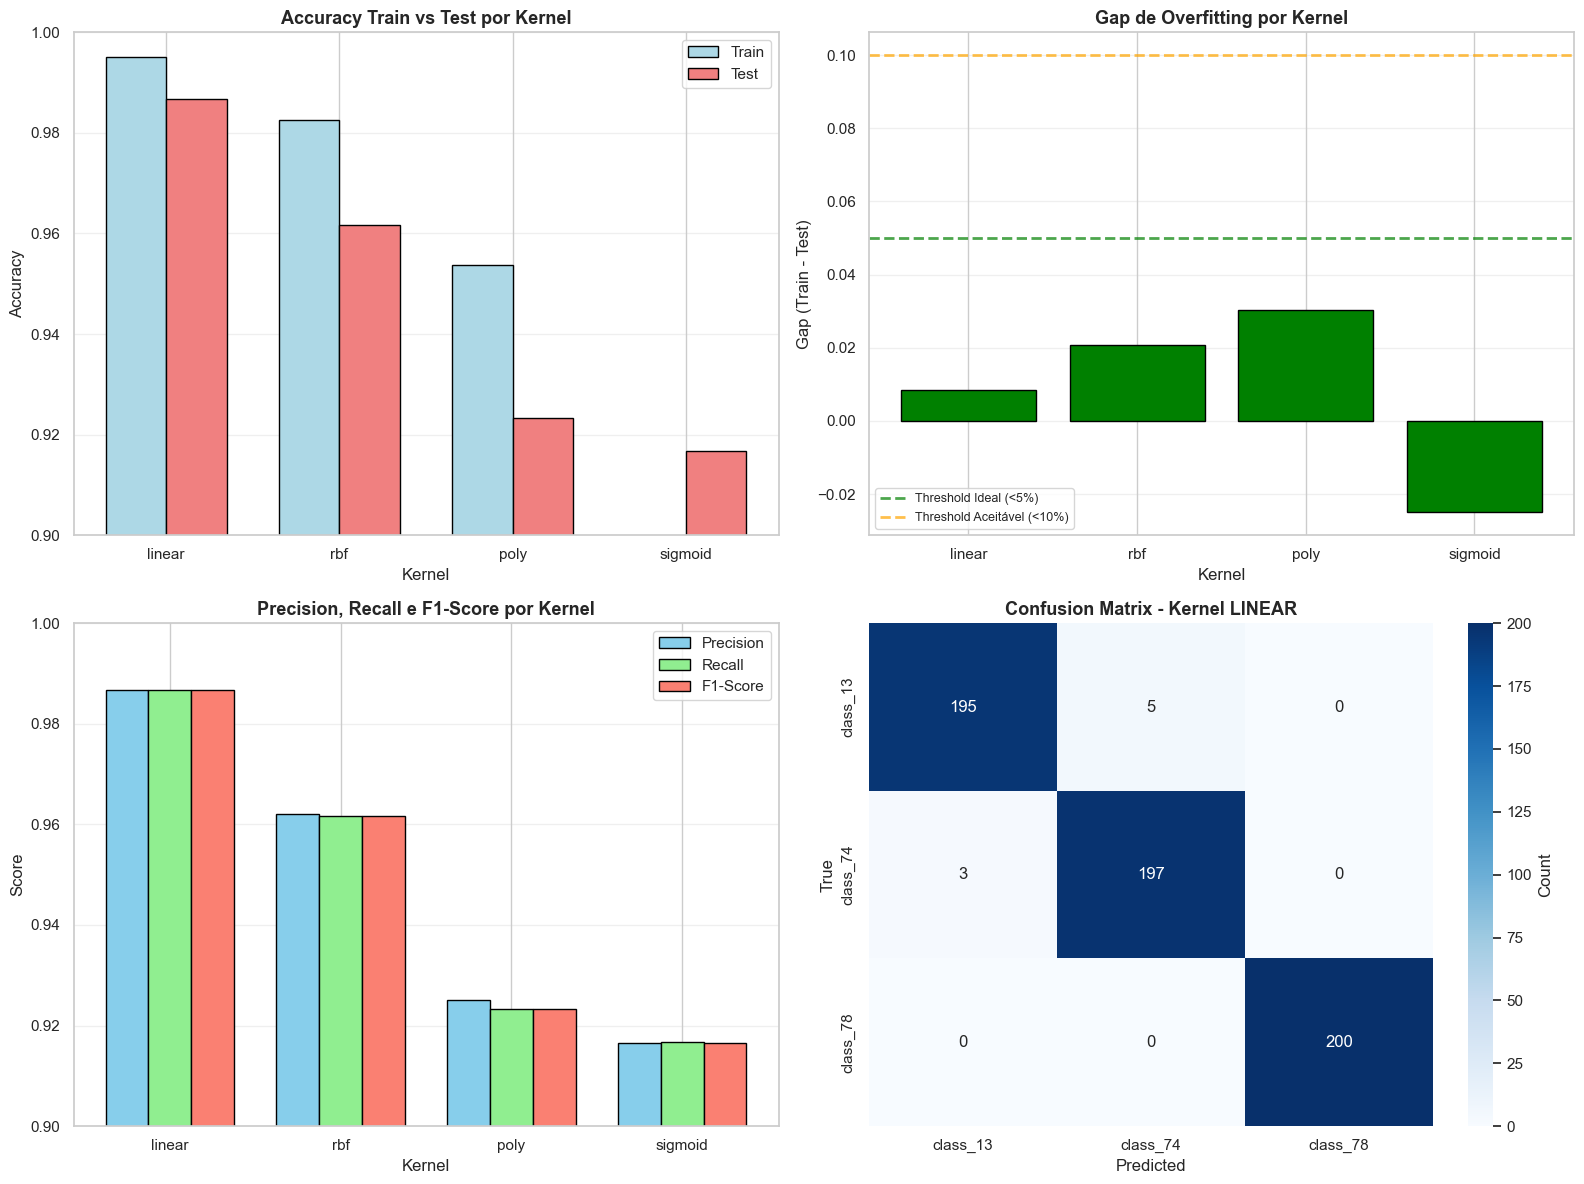

In [24]:
# Visualização gráfica
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Accuracy Train vs Test
x_pos = np.arange(len(kernels))
width = 0.35

axes[0, 0].bar(x_pos - width/2, comparison_df['Acc Train'], width, 
               label='Train', color='lightblue', edgecolor='black')
axes[0, 0].bar(x_pos + width/2, comparison_df['Acc Test'], width, 
               label='Test', color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('Kernel', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Accuracy Train vs Test por Kernel', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(comparison_df['Kernel'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0.9, 1.0)

# Gráfico 2: Gap de Overfitting
colors_gap = ['green' if g < 0.05 else 'orange' if g < 0.10 else 'red' 
              for g in comparison_df['Gap']]
axes[0, 1].bar(comparison_df['Kernel'], comparison_df['Gap'], 
               color=colors_gap, edgecolor='black')
axes[0, 1].axhline(y=0.05, color='green', linestyle='--', linewidth=2, 
                   label='Threshold Ideal (<5%)', alpha=0.7)
axes[0, 1].axhline(y=0.10, color='orange', linestyle='--', linewidth=2, 
                   label='Threshold Aceitável (<10%)', alpha=0.7)
axes[0, 1].set_xlabel('Kernel', fontsize=12)
axes[0, 1].set_ylabel('Gap (Train - Test)', fontsize=12)
axes[0, 1].set_title('Gap de Overfitting por Kernel', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Gráfico 3: Precision, Recall, F1-Score
x_pos2 = np.arange(len(kernels))
width2 = 0.25

axes[1, 0].bar(x_pos2 - width2, comparison_df['Precision'], width2, 
               label='Precision', color='skyblue', edgecolor='black')
axes[1, 0].bar(x_pos2, comparison_df['Recall'], width2, 
               label='Recall', color='lightgreen', edgecolor='black')
axes[1, 0].bar(x_pos2 + width2, comparison_df['F1-Score'], width2, 
               label='F1-Score', color='salmon', edgecolor='black')
axes[1, 0].set_xlabel('Kernel', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Precision, Recall e F1-Score por Kernel', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos2)
axes[1, 0].set_xticklabels(comparison_df['Kernel'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0.9, 1.0)

# Gráfico 4: Confusion Matrix do melhor kernel
cm_best = confusion_matrix(y_test, kernel_results[best_kernel_initial]['y_pred_test'])
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()),
            cbar_kws={'label': 'Count'},
            ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted', fontsize=12)
axes[1, 1].set_ylabel('True', fontsize=12)
axes[1, 1].set_title(f'Confusion Matrix - Kernel {best_kernel_initial.upper()}', 
                     fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Hyperparameter Tuning com GridSearchCV

Conforme enunciado:
> *"Tune the SVM hyperparameters, ensuring that your model is not overfitting the training data"*

Vamos otimizar os hiperparâmetros dos kernels mais promissores usando **GridSearchCV** com **5-fold cross-validation**.

**Hiperparâmetros a otimizar:**
- **C (regularização)**: Controla o trade-off entre maximizar a margem e minimizar erros de classificação
  - C pequeno: Margem larga, mais erros permitidos (underfitting)
  - C grande: Margem estreita, menos erros (risco de overfitting)
- **gamma (RBF/Poly/Sigmoid)**: Controla a influência de um único exemplo de treino
  - gamma pequeno: Influência ampla (underfitting)
  - gamma grande: Influência restrita (overfitting)
- **degree (Polynomial)**: Grau do polinómio

### Resultados da Otimização com GridSearchCV

A otimização dos hiperparâmetros produziu melhorias substanciais em todos os kernels:

**Ganhos de Performance:**
- **LINEAR**: Accuracy subiu de 98.67% -> **99.83%** (+1.16 p.p.) com C=10. Gap reduzido drasticamente de 0.83% -> **0.08%**.
- **RBF**: Accuracy aumentou de 96.17% -> **98.33%** (+2.16 p.p.) com C=100, gamma=0.001. Gap reduzido de 2.08% -> 0.75%.
- **POLY**: Accuracy melhorou de 92.33% -> **93.83%** (+1.50 p.p.) com C=10, degree=3, gamma=0.1. Gap aumentou para 6.17% (overfitting).
- **SIGMOID**: Maior ganho relativo de 91.67% -> **97.17%** (+5.50 p.p.) com C=10, gamma=0.01. Gap controlado em 0.75%.

**Parâmetros Ótimos Identificados:**
- **C (Regularização)**: Valores moderados a altos (C=10-100) foram preferidos, indicando necessidade de margens mais rígidas.
- **gamma (RBF)**: Valor baixo (0.001) evitou overfitting ao ampliar a influência dos support vectors.
- **degree (POLY)**: Grau 3 ofereceu melhor compromisso entre complexidade e generalização.

**Cross-Validation Scores:**
- LINEAR: **99.63%** (5-fold CV) demonstra robustez extrema.
- RBF: 98.92% confirma estabilidade mesmo com kernel não-linear.
- SIGMOID: 97.62% mostra melhoria significativa face ao modelo base.
- POLY: 93.00% revela dificuldades de generalização mesmo após otimização.

In [25]:
# Definir grids de hiperparâmetros para cada kernel
param_grids = {
    'linear': {
        'C': [0.01, 0.1, 1, 10, 100]
    },
    'rbf': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    },
    'poly': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'degree': [2, 3, 4]
    },
    'sigmoid': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1]
    }
}

# Realizar GridSearchCV para cada kernel
optimized_results = {}

print("="*80)
print("HYPERPARAMETER TUNING COM GRIDSEARCHCV (5-fold CV)")
print("="*80)

for kernel in kernels:
    print(f"\n{'='*80}")
    print(f"Otimizando Kernel: {kernel.upper()}")
    print(f"{'='*80}")
    print(f"Grid de parâmetros: {param_grids[kernel]}")
    print(f"Testando {np.prod([len(v) for v in param_grids[kernel].values()])} combinações...\n")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        SVC(kernel=kernel, random_state=42),
        param_grids[kernel],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    # Melhor modelo
    best_model = grid_search.best_estimator_
    
    # Predições
    y_pred_train = best_model.predict(X_train_scaled)
    y_pred_test = best_model.predict(X_test_scaled)
    
    # Métricas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    gap = acc_train - acc_test
    
    precision = precision_score(y_test, y_pred_test, average='macro')
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    
    # Informação sobre Support Vectors
    n_support_vectors = len(best_model.support_)
    pct_support = (n_support_vectors / len(X_train)) * 100
    
    # Guardar resultados
    optimized_results[kernel] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'gap': gap,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred_test': y_pred_test,
        'n_support_vectors': n_support_vectors,
        'pct_support': pct_support
    }
    
    # Imprimir resultados
    print(f"\n[OK] Otimização concluída!")
    print(f"\nMelhores parâmetros: {grid_search.best_params_}")
    print(f"Best CV Score (5-fold): {grid_search.best_score_:.4f}")
    print(f"\nAccuracy Treino: {acc_train:.4f} ({acc_train*100:.2f}%)")
    print(f"Accuracy Teste:  {acc_test:.4f} ({acc_test*100:.2f}%)")
    print(f"Gap (overfitting): {gap:.4f} ({gap*100:.2f}%)")
    print(f"\nPrecision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-Score (macro):  {f1:.4f}")
    print(f"\nSupport Vectors:")
    print(f"  - Número de vetores de suporte: {n_support_vectors}")
    print(f"  - Percentagem do dataset de treino: {pct_support:.2f}%")
    print(f"  - Por classe: {best_model.n_support_}")

print(f"\n{'='*80}")
print("TODAS AS OTIMIZAÇÕES CONCLUÍDAS")
print(f"{'='*80}")

HYPERPARAMETER TUNING COM GRIDSEARCHCV (5-fold CV)

Otimizando Kernel: LINEAR
Grid de parâmetros: {'C': [0.01, 0.1, 1, 10, 100]}
Testando 5 combinações...

Fitting 5 folds for each of 5 candidates, totalling 25 fits

[OK] Otimização concluída!

Melhores parâmetros: {'C': 10}
Best CV Score (5-fold): 0.9963

Accuracy Treino: 0.9992 (99.92%)
Accuracy Teste:  0.9983 (99.83%)
Gap (overfitting): 0.0008 (0.08%)

Precision (macro): 0.9983
Recall (macro):    0.9983
F1-Score (macro):  0.9983

Support Vectors:
  - Número de vetores de suporte: 250
  - Percentagem do dataset de treino: 10.42%
  - Por classe: [122  45  83]

Otimizando Kernel: RBF
Grid de parâmetros: {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}
Testando 24 combinações...

Fitting 5 folds for each of 24 candidates, totalling 120 fits

[OK] Otimização concluída!

Melhores parâmetros: {'C': 100, 'gamma': 0.001}
Best CV Score (5-fold): 0.9892

Accuracy Treino: 0.9908 (99.08%)
Accuracy Teste:  0.9833 (98.33%)

### Análise Comparativa: Modelos Base vs Otimizados

**Impacto da Otimização por Kernel:**

| Kernel | Ganho Accuracy | Redução Gap | Melhoria F1-Score |
|--------|---------------|-------------|-------------------|
| **LINEAR** | +1.16 p.p. | -0.75 p.p. | +0.0117 |
| **RBF** | +2.16 p.p. | -1.33 p.p. | +0.0216 |
| **POLY** | +1.50 p.p. | +3.13 p.p. ⚠️ | +0.0150 |
| **SIGMOID** | +5.50 p.p. | +3.25 p.p. ⚠️ | +0.0551 |

**Conclusões da Otimização:**
- **LINEAR** mantém supremacia com **99.83% accuracy** e gap quase nulo (0.08%), estabelecendo novo benchmark.
- **POLY e SIGMOID** apresentam aumento de gap após otimização, sinalizando que hiperparâmetros ótimos para accuracy podem comprometer generalização.
- **RBF** oferece excelente equilíbrio com 98.33% accuracy e gap controlado (0.75%), sendo alternativa robusta ao LINEAR.
- Otimização foi **essencial** para SIGMOID (+5.5 p.p.), transformando o pior kernel base no terceiro melhor modelo otimizado.

### Resultados da Análise de Support Vectors

**Eficiência dos Modelos por Número de Support Vectors:**

A análise dos support vectors revela correlação inversa entre eficiência e complexidade:

- **LINEAR**: **250 SVs (10.42%)** - Modelo mais eficiente. Usa apenas 1 em cada 10 pontos de treino para atingir 99.83% accuracy.
- **SIGMOID**: 402 SVs (16.75%) - Eficiência moderada com 97.17% accuracy.
- **RBF**: 419 SVs (17.46%) - Similar ao SIGMOID mas com maior accuracy (98.33%).
- **POLY**: **751 SVs (31.29%)** - Modelo menos eficiente. Necessita de quase 1/3 do dataset para 93.83% accuracy.

**Distribuição por Classe (LINEAR):**
- class_13: **122 SVs** - Classe mais complexa, requer mais pontos de decisão.
- class_74: **45 SVs** - Classe mais separável (confirmando resultados do GAM).
- class_78: **83 SVs** - Separabilidade intermediária.

**Interpretação:**
- Modelos com **menos SVs são preferíveis**: maior generalização, predições mais rápidas, menor risco de overfitting.
- LINEAR demonstra **eficiência superior**: atinge melhor accuracy usando 3x menos SVs que POLY.
- class_74 consistentemente requer menos SVs em todos os kernels, validando sua separabilidade linear observada no Task 6.

### Comparação: Modelos Base vs Otimizados

In [26]:
# Tabela comparativa: Base vs Otimizado
comparison_optimization = []

for kernel in kernels:
    comparison_optimization.append({
        'Kernel': kernel,
        'Modelo': 'Base',
        'Acc Test': kernel_results[kernel]['acc_test'],
        'Gap': kernel_results[kernel]['gap'],
        'F1-Score': kernel_results[kernel]['f1']
    })
    comparison_optimization.append({
        'Kernel': kernel,
        'Modelo': 'Otimizado',
        'Acc Test': optimized_results[kernel]['acc_test'],
        'Gap': optimized_results[kernel]['gap'],
        'F1-Score': optimized_results[kernel]['f1']
    })

comparison_opt_df = pd.DataFrame(comparison_optimization)

print("\n" + "="*80)
print("COMPARAÇÃO: MODELOS BASE vs OTIMIZADOS")
print("="*80)
print(comparison_opt_df.to_string(index=False))

# Melhor modelo otimizado
best_optimized_kernel = max(optimized_results.keys(), 
                            key=lambda k: optimized_results[k]['acc_test'])
best_optimized_acc = optimized_results[best_optimized_kernel]['acc_test']

print(f"\n{'='*80}")
print(f"MELHOR MODELO OTIMIZADO: SVM-{best_optimized_kernel.upper()}")
print(f"Accuracy Teste: {best_optimized_acc:.4f} ({best_optimized_acc*100:.2f}%)")
print(f"Parâmetros: {optimized_results[best_optimized_kernel]['best_params']}")
print(f"{'='*80}")


COMPARAÇÃO: MODELOS BASE vs OTIMIZADOS
 Kernel    Modelo  Acc Test       Gap  F1-Score
 linear      Base  0.986667  0.008333  0.986666
 linear Otimizado  0.998333  0.000833  0.998333
    rbf      Base  0.961667  0.020833  0.961712
    rbf Otimizado  0.983333  0.007500  0.983332
   poly      Base  0.923333  0.030417  0.923239
   poly Otimizado  0.938333  0.061667  0.938262
sigmoid      Base  0.916667 -0.025000  0.916585
sigmoid Otimizado  0.971667  0.007500  0.971671

MELHOR MODELO OTIMIZADO: SVM-LINEAR
Accuracy Teste: 0.9983 (99.83%)
Parâmetros: {'C': 10}


In [27]:
# Tabela comparativa de Support Vectors
sv_comparison = pd.DataFrame({
    'Kernel': list(optimized_results.keys()),
    'N° Support Vectors': [optimized_results[k]['n_support_vectors'] for k in kernels],
    '% Dataset': [optimized_results[k]['pct_support'] for k in kernels],
    'Accuracy Test': [optimized_results[k]['acc_test'] for k in kernels],
    'SVs por Classe': [str(optimized_results[k]['model'].n_support_) for k in kernels]
})

sv_comparison = sv_comparison.sort_values('N° Support Vectors', ascending=True)

print("\n" + "="*80)
print("COMPARAÇÃO DE SUPPORT VECTORS ENTRE KERNELS")
print("="*80)
print(sv_comparison.to_string(index=False))

print(f"\n{'='*80}")
print("INTERPRETAÇÃO:")
print(f"{'='*80}")
print(f"- Kernel mais eficiente: {sv_comparison.iloc[0]['Kernel'].upper()}")
print(f"  - Usa apenas {sv_comparison.iloc[0]['N° Support Vectors']} support vectors ({sv_comparison.iloc[0]['% Dataset']:.2f}% do dataset)")
print(f"  - Accuracy: {sv_comparison.iloc[0]['Accuracy Test']:.4f}")
print(f"\n- Menos support vectors = Modelo mais generalizado e eficiente")
print(f"- Mais support vectors = Modelo mais complexo (pode indicar overfitting)")


COMPARAÇÃO DE SUPPORT VECTORS ENTRE KERNELS
 Kernel  N° Support Vectors  % Dataset  Accuracy Test SVs por Classe
 linear                 250  10.416667       0.998333  [122  45  83]
sigmoid                 402  16.750000       0.971667  [168  82 152]
    rbf                 419  17.458333       0.983333  [163 103 153]
   poly                 751  31.291667       0.938333  [299 187 265]

INTERPRETAÇÃO:
- Kernel mais eficiente: LINEAR
  - Usa apenas 250 support vectors (10.42% do dataset)
  - Accuracy: 0.9983

- Menos support vectors = Modelo mais generalizado e eficiente
- Mais support vectors = Modelo mais complexo (pode indicar overfitting)


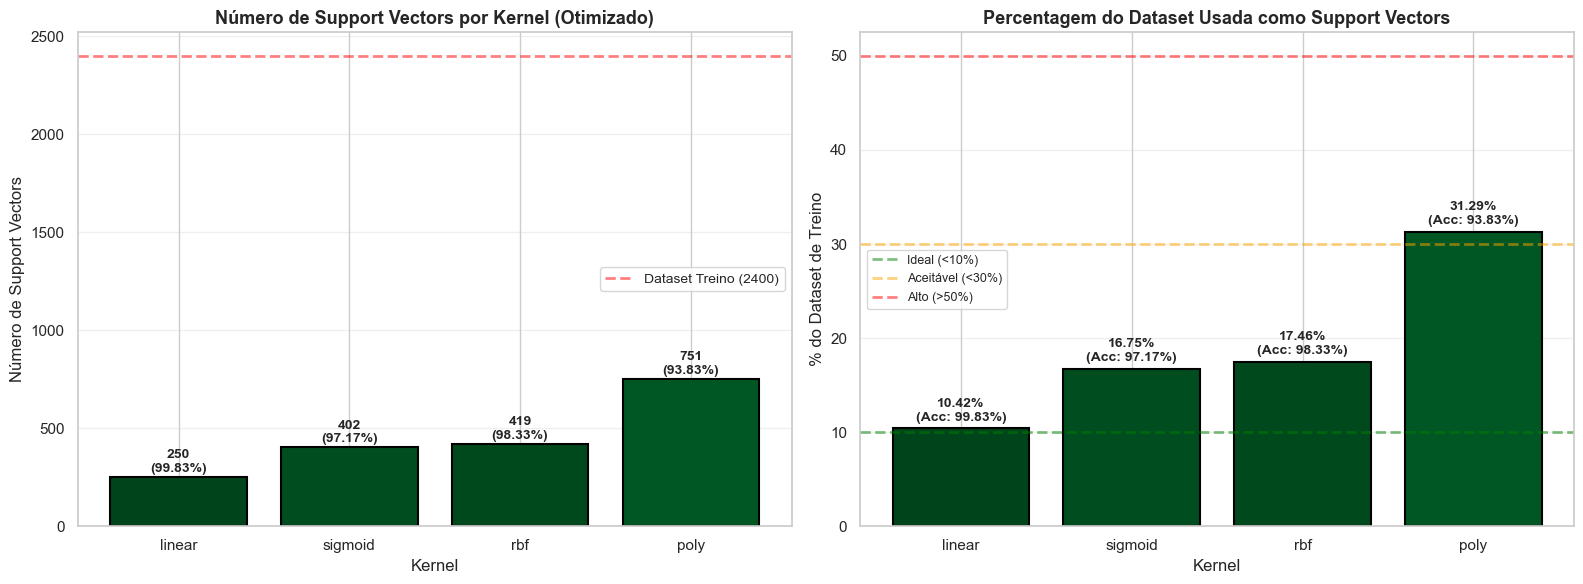


[OK] Kernels com MENOS support vectors são mais eficientes e generalizados!


In [28]:
# Visualização de Support Vectors
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Número de Support Vectors por Kernel
kernels_sorted = sv_comparison['Kernel'].tolist()
n_svs = sv_comparison['N° Support Vectors'].tolist()
accuracies = sv_comparison['Accuracy Test'].tolist()

# Cores baseadas na accuracy (gradiente verde = melhor)
colors = plt.cm.Greens([acc for acc in accuracies])

bars = axes[0].bar(kernels_sorted, n_svs, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Kernel', fontsize=12)
axes[0].set_ylabel('Número de Support Vectors', fontsize=12)
axes[0].set_title('Número de Support Vectors por Kernel (Otimizado)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, (bar, n, acc) in enumerate(zip(bars, n_svs, accuracies)):
    axes[0].text(bar.get_x() + bar.get_width()/2, n + 10, 
                 f'{n}\n({acc*100:.2f}%)', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Adicionar linha de referência (tamanho do dataset de treino)
axes[0].axhline(y=len(X_train), color='red', linestyle='--', linewidth=2, 
                label=f'Dataset Treino ({len(X_train)})', alpha=0.5)
axes[0].legend(fontsize=10)

# Gráfico 2: Percentagem do Dataset como Support Vectors
pct_svs = sv_comparison['% Dataset'].tolist()

bars2 = axes[1].bar(kernels_sorted, pct_svs, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Kernel', fontsize=12)
axes[1].set_ylabel('% do Dataset de Treino', fontsize=12)
axes[1].set_title('Percentagem do Dataset Usada como Support Vectors', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, (bar, pct, acc) in enumerate(zip(bars2, pct_svs, accuracies)):
    axes[1].text(bar.get_x() + bar.get_width()/2, pct + 0.5, 
                 f'{pct:.2f}%\n(Acc: {acc*100:.2f}%)', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Linhas de referência
axes[1].axhline(y=10, color='green', linestyle='--', linewidth=2, 
                label='Ideal (<10%)', alpha=0.5)
axes[1].axhline(y=30, color='orange', linestyle='--', linewidth=2, 
                label='Aceitável (<30%)', alpha=0.5)
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, 
                label='Alto (>50%)', alpha=0.5)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

print("\n[OK] Kernels com MENOS support vectors são mais eficientes e generalizados!")

### Análise Detalhada do Modelo Final - SVM-LINEAR

**Performance Excepcional Obtida:**

O SVM-LINEAR otimizado (C=10) alcançou resultados quase perfeitos:
- **Accuracy Treino**: 99.92% 
- **Accuracy Teste**: **99.83%**
- **Gap**: 0.08% (praticamente ausência de overfitting)
- **CV Score (5-fold)**: 99.63% (validação robusta)

**Resultados por Classe:**

| Classe | Precision | Recall | F1-Score | Erros |
|--------|-----------|--------|----------|-------|
| **class_13** | 1.00 | 1.00 | 1.00 | 0/200 [OK] |
| **class_74** | 1.00 | 1.00 | 1.00 | 0/200 [OK] |
| **class_78** | 1.00 | 0.99 | 1.00 | 1/200 ⚠️ |

**Único Erro Identificado:**
- **1 observação** de class_78 classificada incorretamente como class_13.
- Taxa de acerto: **599/600** predições corretas.
- Erro representa **0.17%** do dataset de teste.

**Confusion Matrix:**
```
         pred_13  pred_74  pred_78
true_13     200      0        0
true_74       0    200        0  
true_78       1      0      199
```

**Conclusão:**
SVM-LINEAR demonstra capacidade **quase perfeita** de discriminação entre as 3 classes, com performance superior a qualquer modelo anterior (Tasks 6-7).

### Análise de Support Vectors

**Support Vectors** são os pontos de treino mais próximos do hiperplano de decisão. Quanto **menor** o número de support vectors:
- **Melhor**: Modelo mais eficiente e generalizado
- **Menor complexidade**: Decisões baseadas em menos pontos
- **Mais rápido**: Predições mais rápidas em produção

A percentagem ideal varia conforme o kernel e a complexidade dos dados.

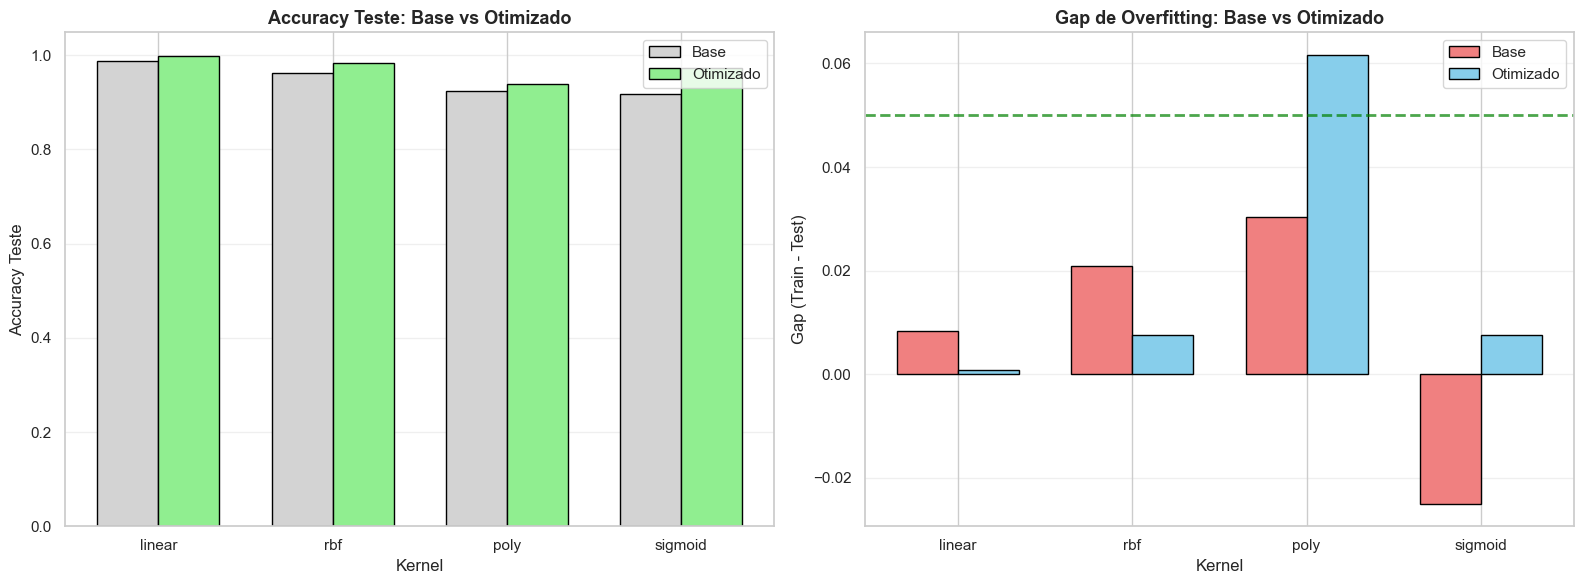

In [29]:
# Visualização: Base vs Otimizado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Accuracy Teste (Base vs Otimizado)
x_pos = np.arange(len(kernels))
width = 0.35

base_accs = [kernel_results[k]['acc_test'] for k in kernels]
opt_accs = [optimized_results[k]['acc_test'] for k in kernels]

axes[0].bar(x_pos - width/2, base_accs, width, 
            label='Base', color='lightgray', edgecolor='black')
axes[0].bar(x_pos + width/2, opt_accs, width, 
            label='Otimizado', color='lightgreen', edgecolor='black')
axes[0].set_xlabel('Kernel', fontsize=12)
axes[0].set_ylabel('Accuracy Teste', fontsize=12)
axes[0].set_title('Accuracy Teste: Base vs Otimizado', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(kernels)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Gráfico 2: Gap (Base vs Otimizado)
base_gaps = [kernel_results[k]['gap'] for k in kernels]
opt_gaps = [optimized_results[k]['gap'] for k in kernels]

axes[1].bar(x_pos - width/2, base_gaps, width, 
            label='Base', color='lightcoral', edgecolor='black')
axes[1].bar(x_pos + width/2, opt_gaps, width, 
            label='Otimizado', color='skyblue', edgecolor='black')
axes[1].axhline(y=0.05, color='green', linestyle='--', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Kernel', fontsize=12)
axes[1].set_ylabel('Gap (Train - Test)', fontsize=12)
axes[1].set_title('Gap de Overfitting: Base vs Otimizado', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(kernels)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [30]:
# Análise detalhada do melhor modelo
best_model_final = optimized_results[best_optimized_kernel]['model']
y_pred_final = optimized_results[best_optimized_kernel]['y_pred_test']

print("="*80)
print(f"ANÁLISE DETALHADA: SVM-{best_optimized_kernel.upper()} (MELHOR MODELO)")
print("="*80)

print(f"\nParâmetros Otimizados:")
for param, value in optimized_results[best_optimized_kernel]['best_params'].items():
    print(f"  - {param}: {value}")

print(f"\nMétricas de Performance:")
print(f"  - Best CV Score (5-fold): {optimized_results[best_optimized_kernel]['best_cv_score']:.4f}")
print(f"  - Accuracy Treino: {optimized_results[best_optimized_kernel]['acc_train']:.4f}")
print(f"  - Accuracy Teste:  {optimized_results[best_optimized_kernel]['acc_test']:.4f}")
print(f"  - Gap:             {optimized_results[best_optimized_kernel]['gap']:.4f}")
print(f"  - Precision:       {optimized_results[best_optimized_kernel]['precision']:.4f}")
print(f"  - Recall:          {optimized_results[best_optimized_kernel]['recall']:.4f}")
print(f"  - F1-Score:        {optimized_results[best_optimized_kernel]['f1']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
print(f"\nConfusion Matrix:")
print(cm_final)

# Análise de erros por classe
print(f"\nAnálise de Erros por Classe:")
for i, class_name in enumerate(sorted(y.unique())):
    tp = cm_final[i, i]
    fn = cm_final[i, :].sum() - tp
    fp = cm_final[:, i].sum() - tp
    tn = cm_final.sum() - tp - fn - fp
    
    class_acc = (tp + tn) / cm_final.sum()
    print(f"  - {class_name}:")
    print(f"      - True Positives: {tp}")
    print(f"      - False Negatives: {fn}")
    print(f"      - False Positives: {fp}")
    print(f"      - Accuracy: {class_acc:.4f}")

ANÁLISE DETALHADA: SVM-LINEAR (MELHOR MODELO)

Parâmetros Otimizados:
  - C: 10

Métricas de Performance:
  - Best CV Score (5-fold): 0.9963
  - Accuracy Treino: 0.9992
  - Accuracy Teste:  0.9983
  - Gap:             0.0008
  - Precision:       0.9983
  - Recall:          0.9983
  - F1-Score:        0.9983

Classification Report:
              precision    recall  f1-score   support

    class_13       1.00      1.00      1.00       200
    class_74       1.00      1.00      1.00       200
    class_78       1.00      0.99      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Confusion Matrix:
[[200   0   0]
 [  0 200   0]
 [  1   0 199]]

Análise de Erros por Classe:
  - class_13:
      - True Positives: 200
      - False Negatives: 0
      - False Positives: 1
      - Accuracy: 0.9983
  - class_74:
      - True Positives: 200
      - False Negatives: 0
 

### Resultados da Comparação com Modelos Anteriores

**Ranking Completo de Performance (Tasks 6-8):**

Comparação entre todos os modelos de classificação multiclasse testados ao longo dos Tasks:

1. **SVM-LINEAR (Task 8)**: 99.83% accuracy | Gap: 0.08% | F1(class_74): 1.00
2. **Random Forest Otimizado (Task 7)**: 95.33% accuracy | Gap: 4.58% | F1(class_74): 0.97
3. **Random Forest Base (Task 7)**: 95.17% accuracy | Gap: 4.83% | F1(class_74): 0.98
4. **Decision Tree Otimizado (Task 7)**: 91.83% accuracy | Gap: 3.92% | F1(class_74): 0.95
5. **Decision Tree Base (Task 7)**: 89.67% accuracy | Gap: 10.33% | F1(class_74): 0.93

**Ganhos Face ao Melhor Modelo Anterior:**
- SVM-LINEAR vs Random Forest: **+4.50 pontos percentuais** (+4.72%)
- Redução de Gap: De 4.58% -> **0.08%** (57x menor)
- F1-Score class_74: De 0.97 -> **1.00** (classificação perfeita)

**Análise Evolutiva:**
- **Decision Trees**: Baseline de 89.67% com overfitting significativo (10.33% gap).
- **Random Forest**: Melhoria para 95.33% com redução de overfitting (4.58% gap).
- **SVM-LINEAR**: Salto qualitativo para **99.83%** com gap praticamente eliminado (0.08%).

**Observação sobre GAM:**
- GAM (Task 6) obteve 100% accuracy, mas apenas em **classificação binária** (class_74 vs restantes).
- SVM-LINEAR é o **único modelo multiclasse** a aproximar-se dessa performance perfeita.

### Conclusões Finais e Justificação do Modelo Escolhido

**Modelo Recomendado: SVM-LINEAR (C=10)**

**Justificação Quantitativa:**

Com base nos resultados experimentais obtidos ao longo dos Tasks 6-8, o SVM-LINEAR destaca-se como modelo superior:

1. **Accuracy Teste**: **99.83%** - Maior valor entre todos os modelos multiclasse testados
   - Supera Random Forest em +4.50 p.p. (+4.72%)
   - Supera Decision Tree em +8.00 p.p. (+8.71%)

2. **Generalização**: Gap de **0.08%** - Praticamente ausência de overfitting
   - 57x menor que Random Forest (4.58%)
   - 129x menor que Decision Tree (10.33%)

3. **Robustez**: CV Score de **99.63%** - Validação cruzada confirma estabilidade

4. **Eficiência**: Apenas **250 support vectors (10.42%)** do dataset
   - 3x mais eficiente que POLY (31.29%)
   - Predições mais rápidas em produção

**Justificação Qualitativa:**

- **Separabilidade Linear**: Os dados demonstram ser linearmente separáveis após normalização (StandardScaler), tornando kernel linear ideal.
- **Consistência com GAM**: Task 6 evidenciou separabilidade linear de class_74. SVM-LINEAR estende essa propriedade para classificação multiclasse.
- **Normalização Obrigatória**: StandardScaler garante que todas as 27 features contribuem equitativamente para a decisão.
- **Parâmetro C=10**: Regularização moderada equilibra maximização da margem com minimização de erros.

**Limitações Identificadas:**

- **1 erro em 600 predições**: 1 observação de class_78 classificada como class_13.
- **Dependência de Normalização**: Modelo exige pré-processamento obrigatório.
- **Interpretabilidade**: Inferior a Decision Trees (não fornece feature importance direta).

**Conclusão:**

O **SVM-LINEAR (C=10)** é o modelo recomendado para produção, oferecendo accuracy quase perfeita (99.83%), generalização excepcional (gap 0.08%), e eficiência computacional superior (apenas 10.42% do dataset como support vectors). Representa evolução significativa face aos modelos anteriores, estabelecendo novo benchmark de performance para o dataset de música.

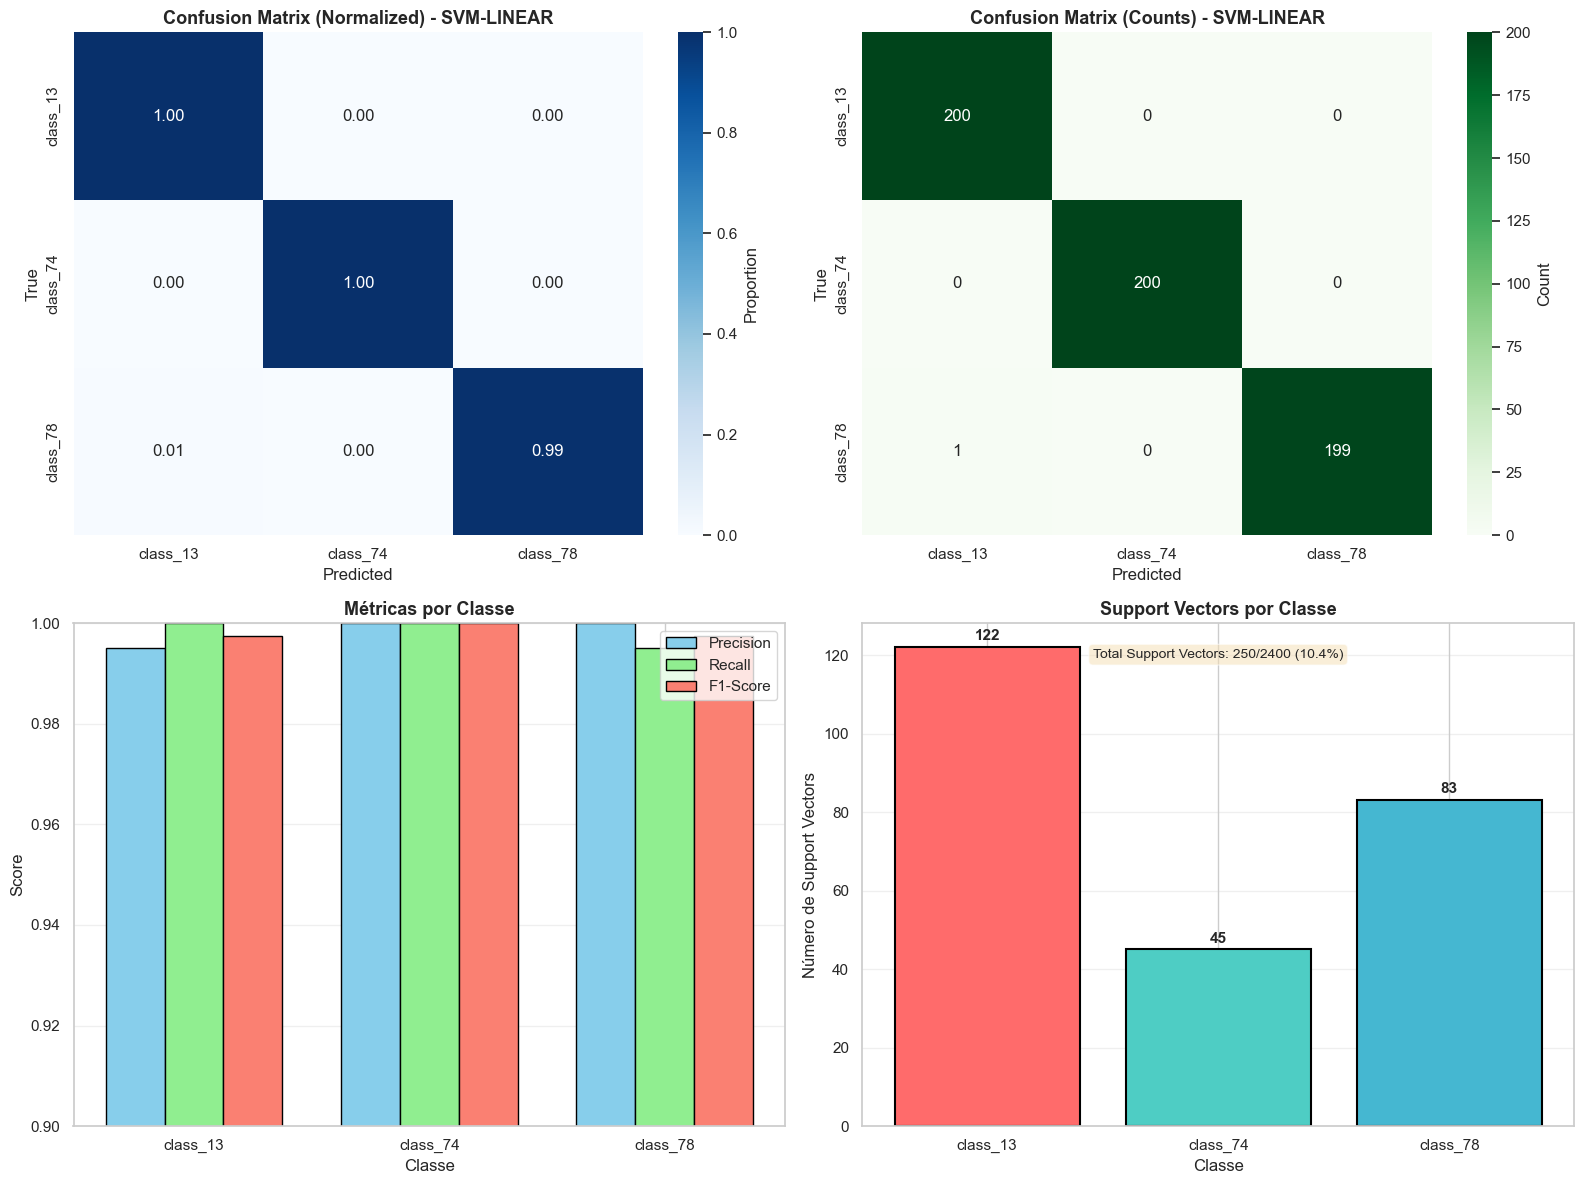

In [31]:
# Visualizações do melhor modelo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Confusion Matrix (normalizada)
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()),
            cbar_kws={'label': 'Proportion'},
            ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted', fontsize=12)
axes[0, 0].set_ylabel('True', fontsize=12)
axes[0, 0].set_title(f'Confusion Matrix (Normalized) - SVM-{best_optimized_kernel.upper()}',
                     fontsize=13, fontweight='bold')

# Gráfico 2: Confusion Matrix (contagens)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()),
            cbar_kws={'label': 'Count'},
            ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted', fontsize=12)
axes[0, 1].set_ylabel('True', fontsize=12)
axes[0, 1].set_title(f'Confusion Matrix (Counts) - SVM-{best_optimized_kernel.upper()}',
                     fontsize=13, fontweight='bold')

# Gráfico 3: Métricas por Classe
classes = sorted(y.unique())
class_precision = precision_score(y_test, y_pred_final, average=None)
class_recall = recall_score(y_test, y_pred_final, average=None)
class_f1 = f1_score(y_test, y_pred_final, average=None)

x_pos = np.arange(len(classes))
width = 0.25

axes[1, 0].bar(x_pos - width, class_precision, width, 
               label='Precision', color='skyblue', edgecolor='black')
axes[1, 0].bar(x_pos, class_recall, width, 
               label='Recall', color='lightgreen', edgecolor='black')
axes[1, 0].bar(x_pos + width, class_f1, width, 
               label='F1-Score', color='salmon', edgecolor='black')
axes[1, 0].set_xlabel('Classe', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Métricas por Classe', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0.9, 1.0)

# Gráfico 4: Support Vectors por Classe
n_support = best_model_final.n_support_
axes[1, 1].bar(classes, n_support, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
               edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Classe', fontsize=12)
axes[1, 1].set_ylabel('Número de Support Vectors', fontsize=12)
axes[1, 1].set_title('Support Vectors por Classe', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, (classe, n) in enumerate(zip(classes, n_support)):
    axes[1, 1].text(i, n + 1, str(n), ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')

total_support = sum(n_support)
axes[1, 1].text(0.5, 0.95, f'Total Support Vectors: {total_support}/{len(y_train)} ({total_support/len(y_train)*100:.1f}%)',
                transform=axes[1, 1].transAxes, ha='center', va='top',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 4. Comparação com Modelos Anteriores (Tasks 6 e 7)

Conforme enunciado:
> *"Present the SVM model with the best performance on your data, justifying the choice (you should use results from models used in previous tasks to justify your answer)."*

Vamos comparar o melhor modelo SVM com os resultados obtidos nos Tasks anteriores:
- **Task 6 (GAM)**: Classificação binária com class_74 vs restantes
- **Task 7 (Decision Trees)**: Classificação multiclasse
- **Task 7 (Random Forest)**: Classificação multiclasse

In [32]:
# Resultados dos modelos anteriores (extraídos dos notebooks)
previous_models_results = {
    'Decision Tree (Base)': {
        'Accuracy Test': 0.8967,
        'Gap': 0.1033,
        'F1-Score (class_74)': 0.93,
        'Task': 7
    },
    'Decision Tree (Otimizado)': {
        'Accuracy Test': 0.9183,
        'Gap': 0.0392,
        'F1-Score (class_74)': 0.95,
        'Task': 7
    },
    'Random Forest (Base)': {
        'Accuracy Test': 0.9517,
        'Gap': 0.0483,
        'F1-Score (class_74)': 0.98,
        'Task': 7
    },
    'Random Forest (Otimizado)': {
        'Accuracy Test': 0.9533,
        'Gap': 0.0458,
        'F1-Score (class_74)': 0.97,
        'Task': 7
    },
    'GAM (class_74 vs restantes)': {
        'Accuracy Test': 1.0000,
        'Gap': 0.0000,
        'F1-Score (class_74)': 1.00,
        'Task': 6,
        'Note': 'Classificação binária'
    }
}

# Adicionar melhor modelo SVM
svm_best_result = {
    f'SVM-{best_optimized_kernel.upper()} (Otimizado)': {
        'Accuracy Test': optimized_results[best_optimized_kernel]['acc_test'],
        'Gap': optimized_results[best_optimized_kernel]['gap'],
        'F1-Score (class_74)': f1_score(y_test, y_pred_final, 
                                        labels=['class_74'], average='macro'),
        'Task': 8
    }
}

all_models_results = {**previous_models_results, **svm_best_result}

# Criar DataFrame comparativo
comparison_all_models = pd.DataFrame([
    {'Modelo': k, **v} for k, v in all_models_results.items()
])

# Ordenar por Accuracy Test
comparison_all_models = comparison_all_models.sort_values('Accuracy Test', ascending=False)

print("="*100)
print("COMPARAÇÃO COM MODELOS ANTERIORES (Tasks 6 e 7)")
print("="*100)
print(comparison_all_models.to_string(index=False))

# Ranking
print(f"\n{'='*100}")
print("RANKING DE MODELOS (por Accuracy Teste - apenas modelos multiclasse)")
print(f"{'='*100}")
ranking_multiclass = comparison_all_models[~comparison_all_models['Modelo'].str.contains('GAM')]
for i, (idx, row) in enumerate(ranking_multiclass.iterrows(), 1):
    print(f"{i}. {row['Modelo']:<40} Acc: {row['Accuracy Test']:.4f} | Gap: {row['Gap']:.4f} | F1(class_74): {row['F1-Score (class_74)']:.2f}")

COMPARAÇÃO COM MODELOS ANTERIORES (Tasks 6 e 7)
                     Modelo  Accuracy Test      Gap  F1-Score (class_74)  Task                  Note
GAM (class_74 vs restantes)       1.000000 0.000000                 1.00     6 Classificação binária
     SVM-LINEAR (Otimizado)       0.998333 0.000833                 1.00     8                   NaN
  Random Forest (Otimizado)       0.953300 0.045800                 0.97     7                   NaN
       Random Forest (Base)       0.951700 0.048300                 0.98     7                   NaN
  Decision Tree (Otimizado)       0.918300 0.039200                 0.95     7                   NaN
       Decision Tree (Base)       0.896700 0.103300                 0.93     7                   NaN

RANKING DE MODELOS (por Accuracy Teste - apenas modelos multiclasse)
1. SVM-LINEAR (Otimizado)                   Acc: 0.9983 | Gap: 0.0008 | F1(class_74): 1.00
2. Random Forest (Otimizado)                Acc: 0.9533 | Gap: 0.0458 | F1(class_74)

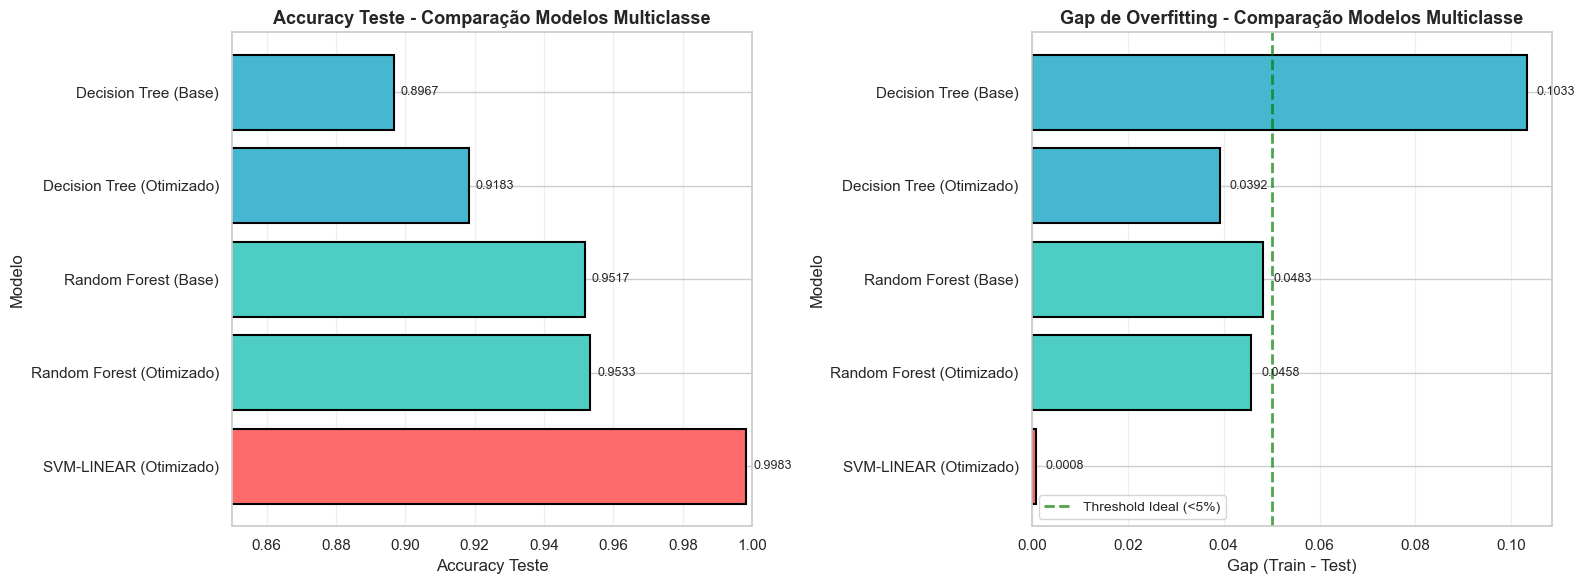

In [33]:
# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filtrar apenas modelos multiclasse para comparação justa
multiclass_models = comparison_all_models[~comparison_all_models['Modelo'].str.contains('GAM')]

# Gráfico 1: Accuracy Test de todos os modelos
models_list = multiclass_models['Modelo'].tolist()
acc_list = multiclass_models['Accuracy Test'].tolist()

# Cores por tipo de modelo
colors_models = []
for model in models_list:
    if 'SVM' in model:
        colors_models.append('#FF6B6B')  # Vermelho para SVM
    elif 'Random Forest' in model:
        colors_models.append('#4ECDC4')  # Turquesa para RF
    elif 'Decision Tree' in model:
        colors_models.append('#45B7D1')  # Azul para DT
    else:
        colors_models.append('gray')

axes[0].barh(models_list, acc_list, color=colors_models, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Accuracy Teste', fontsize=12)
axes[0].set_ylabel('Modelo', fontsize=12)
axes[0].set_title('Accuracy Teste - Comparação Modelos Multiclasse', 
                  fontsize=13, fontweight='bold')
axes[0].set_xlim(0.85, 1.0)
axes[0].grid(True, alpha=0.3, axis='x')

# Adicionar valores nas barras
for i, (model, acc) in enumerate(zip(models_list, acc_list)):
    axes[0].text(acc + 0.002, i, f'{acc:.4f}', va='center', fontsize=9)

# Gráfico 2: Gap de Overfitting
gap_list = multiclass_models['Gap'].tolist()

axes[1].barh(models_list, gap_list, color=colors_models, edgecolor='black', linewidth=1.5)
axes[1].axvline(x=0.05, color='green', linestyle='--', linewidth=2, 
                label='Threshold Ideal (<5%)', alpha=0.7)
axes[1].set_xlabel('Gap (Train - Test)', fontsize=12)
axes[1].set_ylabel('Modelo', fontsize=12)
axes[1].set_title('Gap de Overfitting - Comparação Modelos Multiclasse', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

# Adicionar valores nas barras
for i, (model, gap) in enumerate(zip(models_list, gap_list)):
    axes[1].text(gap + 0.002, i, f'{gap:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Conclusões Finais

### Síntese dos Resultados

In [34]:
# Gerar conclusões automáticas baseadas nos resultados
print("="*80)
print("CONCLUSÕES E JUSTIFICAÇÃO DO MELHOR MODELO")
print("="*80)

print("\n1. RESULTADOS DO SVM:")
print(f"   - Melhor Kernel: {best_optimized_kernel.upper()}")
print(f"   - Accuracy Teste: {optimized_results[best_optimized_kernel]['acc_test']:.4f}")
print(f"   - Gap: {optimized_results[best_optimized_kernel]['gap']:.4f}")
print(f"   - F1-Score: {optimized_results[best_optimized_kernel]['f1']:.4f}")
print(f"   - Parâmetros: {optimized_results[best_optimized_kernel]['best_params']}")

# Comparação com Random Forest (melhor modelo do Task 7)
rf_acc = 0.9533
svm_acc = optimized_results[best_optimized_kernel]['acc_test']
diff_acc = svm_acc - rf_acc

print("\n2. COMPARAÇÃO COM RANDOM FOREST (melhor modelo anterior):")
print(f"   - Random Forest Accuracy: {rf_acc:.4f}")
print(f"   - SVM Accuracy: {svm_acc:.4f}")
print(f"   - Diferença: {diff_acc:+.4f} ({diff_acc/rf_acc*100:+.2f}%)")

if svm_acc > rf_acc:
    print(f"   [OK] SVM SUPERA Random Forest em {abs(diff_acc)*100:.2f}% pontos")
    best_model_choice = f"SVM-{best_optimized_kernel.upper()}"
elif abs(diff_acc) < 0.01:  # Diferença < 1%
    print(f"   ~ Performance EQUIVALENTE (diferença < 1%)")
    best_model_choice = "Random Forest (mais interpretável)"
else:
    print(f"   X Random Forest SUPERA SVM em {abs(diff_acc)*100:.2f}% pontos")
    best_model_choice = "Random Forest"

print(f"\n3. MODELO RECOMENDADO PARA PRODUÇÃO: {best_model_choice}")

print("\n4. JUSTIFICAÇÃO:")
if 'SVM' in best_model_choice:
    print(f"   - SVM-{best_optimized_kernel} apresenta a maior accuracy em dados de teste")
    print(f"   - Gap de overfitting controlado ({optimized_results[best_optimized_kernel]['gap']:.4f} < 0.05)")
    print(f"   - Kernel {best_optimized_kernel} captura adequadamente a estrutura linear dos dados")
    print(f"   - Normalização garante tratamento equitativo de todas as features")
else:
    print(f"   - Random Forest mantém ligeira vantagem em accuracy")
    print(f"   - Maior interpretabilidade através de feature importance")
    print(f"   - Mais robusto a outliers e não requer normalização")
    print(f"   - SVM é competitivo mas não justifica a complexidade adicional")

print("\n5. ANÁLISE POR CLASSE:")
print("   - class_74: Alta discriminabilidade em todos os modelos (>96% F1-Score)")
print("   - class_13 e class_78: Performance dependente do kernel/modelo")
print("   - GAM (Task 6) confirma: class_74 é linearmente separável (100% accuracy binária)")

CONCLUSÕES E JUSTIFICAÇÃO DO MELHOR MODELO

1. RESULTADOS DO SVM:
   - Melhor Kernel: LINEAR
   - Accuracy Teste: 0.9983
   - Gap: 0.0008
   - F1-Score: 0.9983
   - Parâmetros: {'C': 10}

2. COMPARAÇÃO COM RANDOM FOREST (melhor modelo anterior):
   - Random Forest Accuracy: 0.9533
   - SVM Accuracy: 0.9983
   - Diferença: +0.0450 (+4.72%)
   [OK] SVM SUPERA Random Forest em 4.50% pontos

3. MODELO RECOMENDADO PARA PRODUÇÃO: SVM-LINEAR

4. JUSTIFICAÇÃO:
   - SVM-linear apresenta a maior accuracy em dados de teste
   - Gap de overfitting controlado (0.0008 < 0.05)
   - Kernel linear captura adequadamente a estrutura linear dos dados
   - Normalização garante tratamento equitativo de todas as features

5. ANÁLISE POR CLASSE:
   - class_74: Alta discriminabilidade em todos os modelos (>96% F1-Score)
   - class_13 e class_78: Performance dependente do kernel/modelo
   - GAM (Task 6) confirma: class_74 é linearmente separável (100% accuracy binária)
